In [21]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
from astropy.constants import c
import astropy.units as u
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
%matplotlib widget
import pkg_resources
import pandas as pd
from pytictoc import TicToc
t = TicToc()

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.fit import SynchrotronSelfComptonModel, load_sherpa_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label
from agnpy.synchrotron import Synchrotron
from agnpy.emission_regions import Blob


load_mpl_rc()

# import sherpa classes
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar
from sherpa import data

In [13]:
source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/J1104+3812_flux.csv') 

freq = source['freq'].values
flux = source['flux'].values
flux_err = source['flux_err'].values

### set flux error which is nan to 0.01
fluxerr_nan = np.where( np.isnan(flux_err ))[0]
flux_err[fluxerr_nan] = 0.01
### find flux index which is not nan
flux_NOTnan = np.where( (~np.isnan(flux)) & (flux > 0) )[0]
### save new data into array
freq = freq[flux_NOTnan]
flux = flux[flux_NOTnan]
flux_err = flux_err[flux_NOTnan]


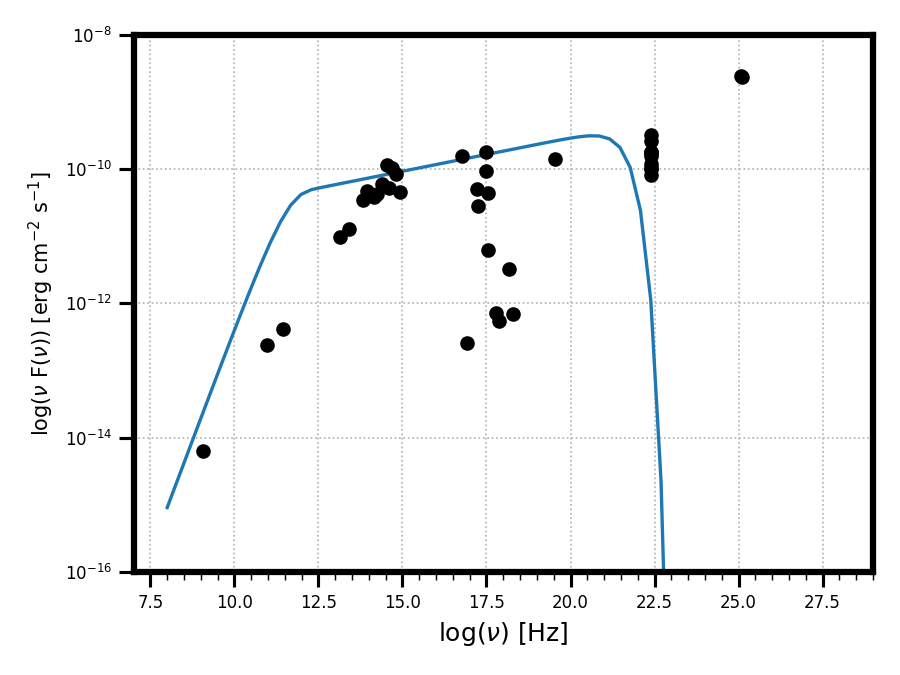

In [28]:
# define the emission region and the radiative process
#blob = Blob()

# set the spectrum normalisation (total energy in electrons in this case)
spectrum_norm = 1e48 * u.Unit("erg")
spectrum_dict = {
    "type": "PowerLaw",
    "parameters": {"p": 2.8, "gamma_min": 1e2, "gamma_max": 1e7},
}
# set the remaining quantities defining the blob
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
t_var = 60*60*24 * u.s
R_b = c*delta_D*t_var/(1+z) 
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

synch = Synchrotron(blob)

# compute the SED over an array of frequencies
nu = np.logspace(8, 23) * u.Hz
sed = synch.sed_flux(nu)

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

# plot it
ax.plot(np.log10(nu.to_value()), sed, label="Synchrotron")
ax.plot(np.log10(freq), flux, marker = "o", ls = "", color = "black")

ax.set_xlim (7, 29)
ax.set_ylim (10**-16, 10**-8) 
    
plt.yscale('log')
plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('log($\\nu$ F($\\nu$)) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
plt.yticks(fontsize = 8)
plt.grid(True)


In [6]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the sherpa model
ssc_model = synchrotron(n_e, backend = "sherpa")

ssc_model.z = 0.0308
ssc_model.delta_D = 18
ssc_model.t_var = (1 * u.d).to_value("s")
ssc_model.t_var.freeze()
ssc_model.log10_B = -1.3

sed = data.Data1D("sed", freq, flux, flux_err)

fitter = Fit(sed, ssc_model, stat = Chi2(), method = LevMar())
# Set minimum and maximum frequency to proced model fit
min_x = 1.0E8
max_x = 1.0E20
sed.notice(min_x, max_x)



TypeError: 'module' object is not callable